In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scroll bar when displaying Folium map
}

<IPython.core.display.Javascript object>

# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! In particular, you will be asked to use data from the Ann Arbor Michigan location (my home!). and this is stored in the file: `assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:
* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write a python notebook which plots line graphs of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015. (Based on the graph, do you think extreme weather is getting more frequent in 2015?)
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

I've written some steps I think would be good to go through, but there are other ways to solve this assignment so feel free to explore the pandas library! What I really want to see is an image that looks like this sketch I drew at my desk:

![](assets/chris_sketch.png)

In [2]:
#  I'll be using the folium package to render the data into a map in Jupyter.

import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('assets/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

## Step 1
Load the dataset and transform the data into Celsius (refer to documentation) then extract all of the rows which have minimum or maximum temperatures.

__hint: when I did this step I had two DataFrame objects, each with ~80,000 entries in it__

In [83]:
import pandas as pd
df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [84]:
# In this code cell, transform the Data_Value column
# Data_Value is scaled by a factor of 10 
df['Data_Value'] = df['Data_Value']/10 

In [85]:
# df_tmin and df_tmax 
df_tmax = df[df['Element'] == 'TMAX']
df_tmin = df[df['Element'] == 'TMIN']
print(df_tmax.head())
print(df_tmin.head())
print(len(df_tmax))
print(len(df_tmin))

            ID        Date Element  Data_Value
0  USW00094889  2014-11-12    TMAX         2.2
2  USC00200032  2008-05-26    TMAX        27.8
3  USC00205563  2005-11-11    TMAX        13.9
4  USC00200230  2014-02-27    TMAX       -10.6
5  USW00014833  2010-10-01    TMAX        19.4
             ID        Date Element  Data_Value
1   USC00208972  2009-04-29    TMIN         5.6
6   USC00207308  2010-06-29    TMIN        14.4
8   USW00004848  2007-12-14    TMIN        -1.6
11  USC00205822  2008-05-29    TMIN         2.8
12  USC00203712  2008-10-17    TMIN         1.7
83063
82022


## Step 2
In order to visualize the data we would plot the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But we also need to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

If you did step 1 you have two Series objects with min and max times for the years 2005 through 2015. You can use Pandas `groupby` to create max and min temperature Series objects across all weather stations for each day of these years, and you can deal with the records for February 29 (the leap year) by dropping them.

__hint: when I finished this step, I had two DataFrame objects, each with exactly 4015 observations in them__

In [86]:
# create a DataFrame of maximum temperature by date
# ensure date column is in datetime format 
df_tmax['Date'] = pd.to_datetime(df_tmax['Date'])
# create copy of df_tmax w/o 2015 entries 
df_tmax_05_14 = df_tmax[df_tmax['Date'].dt.year != 2015].copy()
# group by the month and day 
df_tmax_05_14['Month_Day'] = df_tmax_05_14['Date'].dt.strftime('%m-%d')
max_tmax_by_day = df_tmax_05_14.groupby('Month_Day')['Data_Value'].max()
# remove 29 Feb from the max_tmax_by_day dataset 
max_tmax_by_day = max_tmax_by_day.drop('02-29', errors='ignore') 
print(df_tmax_05_14.head())
print(max_tmax_by_day)

# create a DataFrame of minimum temperatures by date
# ensure date column is in datetime format 
df_tmin['Date'] = pd.to_datetime(df_tmin['Date'])
# create copy of df_tmax w/o 2015 entries 
df_tmin_05_14 = df_tmin[df_tmin['Date'].dt.year != 2015].copy()
# group by the month and day 
df_tmin_05_14['Month_Day'] = df_tmin_05_14['Date'].dt.strftime('%m-%d')
min_tmin_by_day = df_tmin_05_14.groupby('Month_Day')['Data_Value'].min()
# remove 29 Feb from the min_tmin_by_day dataset 
min_tmin_by_day = min_tmin_by_day.drop('02-29', errors='ignore') 
print(df_tmin_05_14.head())
print(min_tmin_by_day)

            ID       Date Element  Data_Value Month_Day
0  USW00094889 2014-11-12    TMAX         2.2     11-12
2  USC00200032 2008-05-26    TMAX        27.8     05-26
3  USC00205563 2005-11-11    TMAX        13.9     11-11
4  USC00200230 2014-02-27    TMAX       -10.6     02-27
5  USW00014833 2010-10-01    TMAX        19.4     10-01
Month_Day
01-01    15.6
01-02    13.9
01-03    13.3
01-04    10.6
01-05    12.8
         ... 
12-27    18.9
12-28    19.4
12-29    12.8
12-30    11.7
12-31    13.9
Name: Data_Value, Length: 365, dtype: float64
             ID       Date Element  Data_Value Month_Day
1   USC00208972 2009-04-29    TMIN         5.6     04-29
6   USC00207308 2010-06-29    TMIN        14.4     06-29
8   USW00004848 2007-12-14    TMIN        -1.6     12-14
11  USC00205822 2008-05-29    TMIN         2.8     05-29
12  USC00203712 2008-10-17    TMIN         1.7     10-17
Month_Day
01-01   -16.0
01-02   -26.7
01-03   -26.7
01-04   -26.1
01-05   -15.0
         ... 
12-27   -13.8
12-2

## Step 3
Now that you have grouped the daily max and min temperatures for each day of the years 2005 through 2015, you can separate out the data for 2015. Then you can use the Pandas `groupby` function to find the max and min of the temperature data for each __day of the year__ for the 2005-2014 data.

__hint: at the end of this step I had two DataFrames, one of maximum and the other of minimum values, which each had 365 observations in them. I also had another pair of similar DataFrames but only for the year 2015.__

In [87]:
# calculate the minimum and maximum values for the day of the year for 2005 through 2014

# calculate the minimum and maximum values for the years 2015
df_tmax_2015 = df_tmax[df_tmax['Date'].dt.year == 2015].copy()
df_tmax_2015['Month_Day'] = df_tmax_2015['Date'].dt.strftime('%m-%d')
max_tmax_2015 = df_tmax_2015.groupby('Month_Day')['Data_Value'].max()
max_tmax_2015 = max_tmax_2015.drop('02-29', errors='ignore') 
print(max_tmax_2015.head())

df_tmin_2015 = df_tmin[df_tmin['Date'].dt.year == 2015].copy()
df_tmin_2015['Month_Day'] = df_tmin_2015['Date'].dt.strftime('%m-%d')
min_tmin_2015 = df_tmin_2015.groupby('Month_Day')['Data_Value'].min()
min_tmin_2015 = min_tmin_2015.drop('02-29', errors='ignore') 
print(min_tmin_2015.head())

# we want to compare max_tmax_2015 to max_tmax_05_14 
# max_tmax_2015 values only show up if > max_tmax_05_14 for that month_day 
# same for tmin 

Month_Day
01-01    1.1
01-02    3.9
01-03    3.9
01-04    4.4
01-05    2.8
Name: Data_Value, dtype: float64
Month_Day
01-01   -13.3
01-02   -12.2
01-03    -6.7
01-04    -8.8
01-05   -15.5
Name: Data_Value, dtype: float64


## Step 4
Now it's time to plot! You need to explore matplotlib in order to plot line graphs of the min and max temperatures for the years 2005 through 2014 and to scatter plot __only__ the daily 2015 temperatures that exceeded those values.

In [88]:
# convert the max_tmax series into a dataframe 
max_tmax_by_day = max_tmax_by_day.reset_index() 
max_tmax_by_day.columns = ['Month_Day', 'Data_Value']

max_tmax_by_day['Month'] = max_tmax_by_day['Month_Day'].str[:2].map({
    '01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr',
    '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug',
    '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'
})
max_tmax_by_day.head()

,Month_Day,Data_Value,Month
0,01-01,15.6,Jan
1,01-02,13.9,Jan
2,01-03,13.3,Jan
3,01-04,10.6,Jan
4,01-05,12.8,Jan


In [89]:
# convert the min_tmin series into a dataframe 
min_tmin_by_day = min_tmin_by_day.reset_index() 
min_tmin_by_day.columns = ['Month_Day', 'Data_Value']

min_tmin_by_day['Month'] = min_tmin_by_day['Month_Day'].str[:2].map({
    '01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr',
    '05': 'May', '06': 'Jun', '07': 'Jul', '08': 'Aug',
    '09': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'
})
max_tmax_by_day.head()
min_tmin_by_day.head()

,Month_Day,Data_Value,Month
0,01-01,-16.0,Jan
1,01-02,-26.7,Jan
2,01-03,-26.7,Jan
3,01-04,-26.1,Jan
4,01-05,-15.0,Jan


In [102]:
max_tmax_by_day.head()

,Month_Day,Data_Value,Month
0,01-01,15.6,Jan
1,01-02,13.9,Jan
2,01-03,13.3,Jan
3,01-04,10.6,Jan
4,01-05,12.8,Jan


In [99]:
max_tmax_2015 = max_tmax_2015.reset_index() 
max_tmax_2015.columns = ['Month_Day', 'Data_Value']
max_tmax_2015.head()

In [103]:
# now pick out rows of tmax_2015 that should be plotted as a scatterplot 
tmax_comparison = pd.merge(max_tmax_2015, max_tmax_by_day[['Month_Day', 'Data_Value']], on="Month_Day", suffixes=('_2015','_Prev'))

# filter 2015 data that is higher 
tmax_higher_2015 = tmax_comparison[tmax_comparison['Data_Value_2015'] > tmax_comparison['Data_Value_Prev']]
print(tmax_higher_2015)

    Month_Day  Data_Value_2015  Data_Value_Prev
39      02-09              8.3              7.8
106     04-17             27.8             24.4
126     05-07             30.6             25.6
127     05-08             33.3             31.7
130     05-11             30.6             29.4
137     05-18             31.7             28.9
207     07-27             33.9             33.3
209     07-29             36.1             33.9
230     08-19             32.8             32.2
249     09-07             35.0             34.4
250     09-08             33.9             33.3
258     09-16             31.1             27.8
259     09-17             31.7             28.9
260     09-18             30.0             29.4
270     09-28             29.4             28.3
271     09-29             28.3             27.8
292     10-20             27.2             22.2
305     11-02             22.8             21.1
306     11-03             26.1             22.8
307     11-04             26.1          

In [105]:
# now pick out rows of tmin_2015 that should be plotted as a scatterplot 
tmin_comparison = pd.merge(min_tmin_2015, min_tmin_by_day[['Month_Day', 'Data_Value']], on="Month_Day", suffixes=('_2015','_Prev'))

# filter 2015 data that is lower 
tmin_lower_2015 = tmin_comparison[tmin_comparison['Data_Value_2015'] < tmin_comparison['Data_Value_Prev']]
print(tmin_lower_2015)

    Month_Day  Data_Value_2015  Data_Value_Prev
4       01-05            -15.5            -15.0
10      01-11            -20.0            -18.3
33      02-03            -23.8            -23.2
44      02-14            -23.9            -21.7
45      02-15            -26.0            -25.6
46      02-16            -29.4            -22.2
47      02-17            -27.2            -24.3
49      02-19            -26.0            -18.8
50      02-20            -34.3            -17.8
51      02-21            -32.2            -17.8
53      02-23            -26.7            -22.8
54      02-24            -27.2            -21.1
55      02-25            -21.7            -17.2
56      02-26            -21.6            -20.0
57      02-27            -28.8            -23.8
58      02-28            -27.2            -27.1
63      03-05            -22.1            -18.9
64      03-06            -25.5            -17.8
65      03-07            -22.2            -17.8
86      03-28            -12.2          

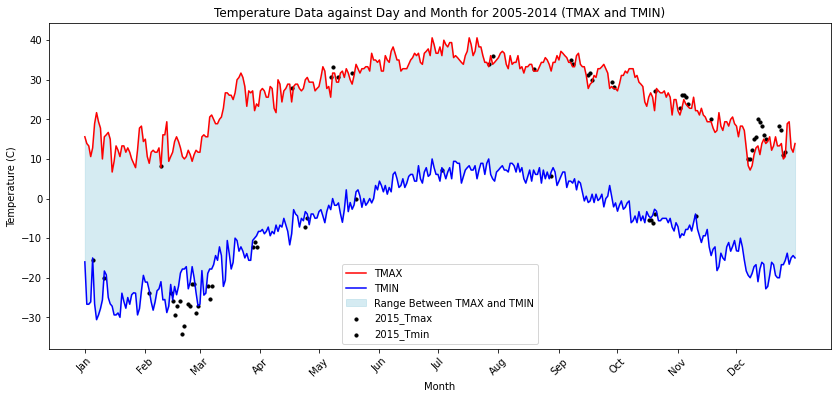

In [116]:
import matplotlib.pyplot as plt
from calendar import month_abbr

# put your plotting code here!


# plot both tmax and tmin on the same graph (line graph)
plt.figure(figsize=(14,6))
plt.plot(max_tmax_by_day['Month_Day'], max_tmax_by_day['Data_Value'],
         marker='o', markersize=0, linestyle='-', color='red', label ='TMAX')
plt.plot(min_tmin_by_day['Month_Day'], min_tmin_by_day['Data_Value'],
         marker='o', markersize = 0, linestyle='-', color='blue', label ='TMIN')

# fill_between tmax and tmin
plt.fill_between(max_tmax_by_day['Month_Day'], max_tmax_by_day['Data_Value'], min_tmin_by_day['Data_Value'],
                 color='lightblue', alpha=0.5, label='Range Between TMAX and TMIN')

# add scatter plots for 2015 data 
plt.scatter(tmax_higher_2015['Month_Day'], tmax_higher_2015['Data_Value_2015'], color='black', s=10, label='2015_Tmax')
plt.scatter(tmin_lower_2015['Month_Day'], tmin_lower_2015['Data_Value_2015'], color='black', s=10, label='2015_Tmin')

# add labels, title and legend 
# set custom xticks and labels 
month_ticks = max_tmax_by_day.groupby('Month')['Month_Day'].first()
plt.xticks(month_ticks.values, month_ticks.index, rotation=45)

plt.title('Temperature Data against Day and Month for 2005-2014 (TMAX and TMIN)')
plt.xlabel('Month') 
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(False)
plt.savefig('temperature_data_plot.png', dpi=300, bbox_inches='tight')
plt.show()